# Library

import os
os.chdir('autodl-tmp/code_Yao')
os.getcwd()

In [1]:
import csv
import time
import math
import argparse
import random
from random import seed
from mylib.utils import fix_seed
from mylib.data.data_loader import load_ucidata
import numpy as np
from run_dnl import run_dnl
import tools
import pandas as pd
from kmeans import run_kmeans
import os
import argparse
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import collections
%matplotlib inline


# Parser

In [2]:
from kmeans import run_kmeans
# --- parsing and configuration --- #
parser = argparse.ArgumentParser(
    description="PyTorch implementation of VAE")
parser.add_argument('--batch_size', type=int, default=16,
                    help='batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10,
                    help='number of epochs to train (default: 20)')
parser.add_argument('--z_dim', type=int, default=25,
                    help='dimension of hidden variable Z (default: 10)')
parser.add_argument('--num_hidden_layers', type=int, default=2,
                    help='num hidden_layers (default: 0)')
parser.add_argument('--flip_rate_fixed', type=float,
                    help='fixed flip rates.', default=0.4)
parser.add_argument('--train_frac', default=1.0, type=float,
                    help='training sample size fraction')
parser.add_argument('--noise_type', type=str, default='sym')
parser.add_argument('--trainval_split',  default=0.8, type=float,
                    help='training set ratio')
parser.add_argument('--seed', default=1, type=int,
                    help='seed for initializing training')
parser.add_argument('--dataset', default="krkp", type=str,
                    help='db')
parser.add_argument('--select_ratio', default=0, type=float,
                    help='confidence example selection ratio')
parser.add_argument('--pretrained', default=0, type=int,
                    help='using pretrained model or not')

# added by yz:
parser.add_argument('--pca_k', type=int, default=5,
                    help='PCA dimension (default: 5)')
parser.add_argument('--sample_size', type=int, default=20,
                    help='randomly select samples for analysis')
parser.add_argument('--near_percentage', type=float, default=0.1,
                    help='percentage nearby in terms of L2 norm')

arch_dict = {"FashionMNIST": "resnet18", "cifar10": "resnet18", "cifar100": "resnet34", "mnist": "Lenet",
             "balancescale": "NaiveNet", "krkp": "NaiveNet", "splice": "NaiveNet", "yxguassian": "NaiveNet"}


# Define functions

In [3]:
def runPCA(dataset, n_components):
    X = dataset.data
    pca = PCA(n_components)
    return pca.fit(X)


def entropy(labels):
    freqdist = collections.Counter(labels)
    probs = [freqdist[label] / len(labels) for label in freqdist]
    return -sum(p * math.log(p, 2) for p in probs)


# Load dataset

In [10]:
args = parser.parse_args(
    args=["--dataset", "yxguassian", "--near_percentage", "0.05", "--sample_size", "100"])
base_dir = "./"+args.dataset+"/"+args.noise_type + \
    str(args.flip_rate_fixed)+"/"+str(args.seed)+"/"
print(args)

if args.seed is not None:
    fix_seed(args.seed)
train_val_loader, train_loader, val_loader, est_loader, test_loader = load_ucidata(
    dataset=args.dataset,
    noise_type=args.noise_type,
    random_state=args.seed,
    batch_size=args.batch_size,
    add_noise=True,
    flip_rate_fixed=args.flip_rate_fixed,
    trainval_split=args.trainval_split,
    train_frac=args.train_frac,
    augment=False,
)
# only use training data, no validation and test data is used
# test_dataset = test_loader.dataset
# val_dataset = val_loader.dataset
train_dataset = train_loader.dataset


Namespace(batch_size=16, epochs=10, z_dim=25, num_hidden_layers=2, flip_rate_fixed=0.4, train_frac=1.0, noise_type='sym', trainval_split=0.8, seed=1, dataset='yxguassian', select_ratio=0, pretrained=0, pca_k=5, sample_size=100, near_percentage=0.05)


# Results t-SNE

In [17]:
from sklearn.manifold import TSNE
time_start = time.time()
sample_size = 100
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
random_select_index = np.random.choice(
    len(train_dataset.dataset.data), sample_size, replace=False)
X_tsne = tsne.fit_transform(train_dataset.dataset.data[random_select_index])
time_end = time.time()
print('t-SNE cost', time_end - time_start, 's')


t-SNE cost 1.7684338092803955 s


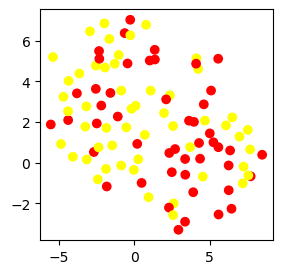

In [18]:
plt.figure(figsize=(3, 3))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
            c=train_dataset.dataset.targets[random_select_index], cmap='autumn_r')


# Results PCA
Run PCA and plot the result

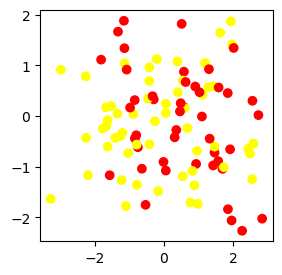

In [23]:
k = args.pca_k
iteration_number = args.sample_size
near_percentage = args.near_percentage

# --- PCA --- #
pca = runPCA(train_dataset.dataset, k)

X_pca = pca.transform(train_dataset.dataset.data)

plt.figure(figsize=(3, 3))
sample_size = 100
random_select_index = np.random.choice(
    len(train_dataset.dataset.data), sample_size, replace=False)
X_pca_sample = X_pca[random_select_index]
plt.scatter(X_pca_sample[:, 0], X_pca_sample[:, 1],
            c=train_dataset.dataset.targets[random_select_index], cmap='autumn_r')


In [ ]:

# calculate class 0 ratio for binary classification
if len(np.unique(train_dataset.dataset.targets)) == 2:
    is_binary = True
else:
    is_binary = False

random_index_list = []
entropy_list = []
ratio_list = []
for i in range(iteration_number):
    while (1):
        random_index = random.randint(0, len(train_dataset.dataset.data))
        if (random_index not in random_index_list):
            random_index_list.append(random_index)
            break

    l2_norm = np.linalg.norm(X_pca - X_pca[random_index], axis=1)
    # find the index of examples that are close to the randomly selected example
    close_samples_index = np.argsort(l2_norm)[:int(
        len(train_dataset.dataset.data)*near_percentage)]
    # calculate the entropy among these samples
    close_entropy = entropy(train_dataset.dataset.targets[close_samples_index])
    entropy_list.append(close_entropy)

    # for binary labels, calculate the ratio of count the unique values of targets
    if (is_binary == True):
        unique, counts = np.unique(
            train_dataset.dataset.targets[close_samples_index], return_counts=True)
        ratio = counts[0]/(counts[0]+counts[1])
        ratio_list.append(ratio)
    else:
        ratio_list.append(0)

# concatenate the random index, entropy and ratio lists into a dataframe
df = pd.DataFrame(list(zip(random_index_list, entropy_list, ratio_list)), columns=[
                  'random_index', 'entropy', 'class0_ratio'])
entropy_mean = df['entropy'].mean()
entropy_var = df['entropy'].var()
print("Done")


## results in table

In [13]:
# create csv file
output_filename = "./results/pca_results.csv"
# with open(output_filename, 'a', newline = '') as file:
#     writer = csv.writer(file)
#     writer.writerow(["dataset", "pca_k", "sample_size", "near_percentage", "noise_type", "flip_rate_fixed", "entropy_mean","entropy_variance", "ratio_mean", "ratio_variance"])

# write results to csv file


## plot the results

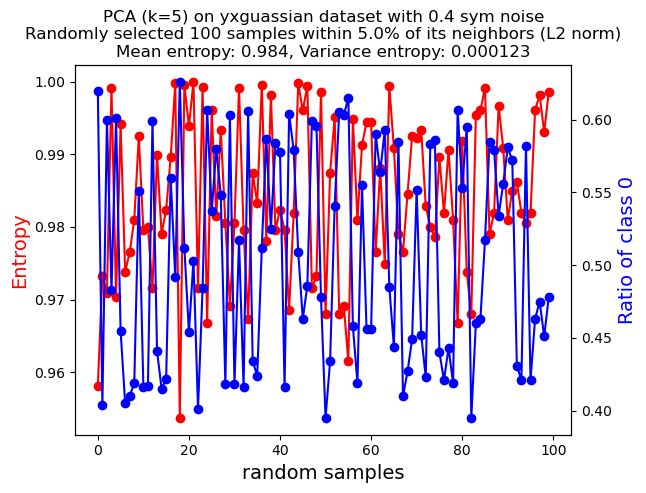

In [20]:

save_fig = 0
# visulization:
y_axis_label_left = "Entropy"
y_axis_label_right = "Ratio of class 0"
title = "PCA (k="+str(k)+") on "+args.dataset+" dataset"+" with "+str(args.flip_rate_fixed)+" "+str(args.noise_type)+" noise"+'\n' + "Randomly selected "+str(iteration_number) + \
    " samples within "+str(near_percentage*100)+"% of its neighbors (L2 norm)"+'\n' + "Mean entropy: " + \
    str(round(entropy_mean, 3))+", Variance entropy: "+str(round(entropy_var, 6))

# create figure and axis objects with subplots()
fig, ax = plt.subplots()
# make a plot
ax.plot(df.index,
        df.entropy,
        color="red",
        marker="o")
# set x-axis label
ax.set_xlabel("random samples", fontsize=14)
# set y-axis label
ax.set_ylabel(y_axis_label_left,
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df.index, df.class0_ratio, color="blue", marker="o")
ax2.set_ylabel(y_axis_label_right, color="blue", fontsize=14)

# ax.set_ylim(0,1.1)
# ax2.set_ylim(0,1.1)
plt.title(title)
plt.show()

# save the plot as a file
output_path = "./results/"+str(args.dataset)+"_PCA_"+str(args.pca_k)+"_random_"+str(args.sample_size) + \
    "_near_"+str(near_percentage)+"_"+str(args.noise_type) + \
    "_"+str(args.flip_rate_fixed)+"_noise"+".png"

if save_fig == 1:
    fig.savefig(output_path,
                format='jpeg',
                dpi=100,
                bbox_inches='tight')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv("./results/pca_results.csv")


In [4]:
df


,dataset,pca_k,sample_size,near_percentage,noise_type,flip_rate_fixed,entropy_mean,entropy_variance,ratio_mean,ratio_variance,causal
0,xyguassian,5,200,0.10,sym,0.1,0.834760,0.027324,0.501022,0.052966,0
1,xyguassian,5,200,0.30,sym,0.1,0.935229,0.005730,0.498111,0.021744,0
2,xyguassian,5,200,0.50,sym,0.1,0.973792,0.000942,0.496543,0.008985,0
3,xyguassian,3,200,0.10,sym,0.1,0.880818,0.014377,0.507352,0.039091,0
4,xyguassian,3,200,0.30,sym,0.1,0.940327,0.003990,0.500893,0.020168,0
...,...,...,...,...,...,...,...,...,...,...,...
1565,splice,3,1000,0.05,pair,0.9,1.246513,0.049203,0.000000,0.000000,1
1566,splice,3,1000,0.10,pair,0.9,1.293344,0.035138,0.000000,0.000000,1
1567,splice,1,1000,0.01,pair,0.9,1.258111,0.040965,0.000000,0.000000,1
1568,splice,1,1000,0.05,pair,0.9,1.324988,0.018468,0.000000,0.000000,1


In [6]:
df
xx=23
y=4
xx=23+1

,dataset,pca_k,sample_size,near_percentage,noise_type,flip_rate_fixed,entropy_mean,entropy_variance,ratio_mean,ratio_variance,causal
0,xyguassian,5,200,0.10,sym,0.1,0.834760,0.027324,0.501022,0.052966,0
1,xyguassian,5,200,0.30,sym,0.1,0.935229,0.005730,0.498111,0.021744,0
2,xyguassian,5,200,0.50,sym,0.1,0.973792,0.000942,0.496543,0.008985,0
3,xyguassian,3,200,0.10,sym,0.1,0.880818,0.014377,0.507352,0.039091,0
4,xyguassian,3,200,0.30,sym,0.1,0.940327,0.003990,0.500893,0.020168,0
...,...,...,...,...,...,...,...,...,...,...,...
1565,splice,3,1000,0.05,pair,0.9,1.246513,0.049203,0.000000,0.000000,1
1566,splice,3,1000,0.10,pair,0.9,1.293344,0.035138,0.000000,0.000000,1
1567,splice,1,1000,0.01,pair,0.9,1.258111,0.040965,0.000000,0.000000,1
1568,splice,1,1000,0.05,pair,0.9,1.324988,0.018468,0.000000,0.000000,1


In [1]:
import numpy as np
X=np.array([[1,2],[3,4],[5,6]])
plt.legend()